In [10]:
import multiprocessing
import os
import random
import sys
import numpy as np
from PIL import Image, ImageFilter


random.seed(2)

# Setup input and output directories.
input_directory = 'card-images'
output_directories = ('rgba-images', 'greyscaled-images', 'rgba-data', 'greyscaled-data')
for output_directory in output_directories:
  if not os.path.exists(output_directory):
    os.makedirs(output_directory)
  
# Cropping params.
original_card_width, original_card_height = 352, 550

# Resizing params.
card_width, card_height = 150, 150


def preprocess(input_image_data):
  """Preprocess images.
  
  The input is a tuple: (path, param-dict).
  """
  input_path, params = input_image_data
  image = Image.open(input_path)
  cropped_image = image.crop((0, 0, original_card_width, original_card_height))
  intensified_image = cropped_image.point(lambda p: p * params['intensification'])
  rotated_image = intensified_image.rotate(params['rotation'], expand=True, resample=Image.BICUBIC)
  resized_image = rotated_image.resize((card_width, card_height), resample=Image.ANTIALIAS)
  blurred_image = resized_image.filter(ImageFilter.GaussianBlur(params['blur']))
  greyscaled_image = blurred_image.convert('L')
  rgba_data = np.array(blurred_image).flatten()
  greyscaled_data = np.array(greyscaled_image).flatten()
  # Parse the input path.
  filename = input_path.split('/')[-1]
  params['number'] = filename.split('-')[0]
  params['color'] = filename.split('-')[1]
  params['texture'] = filename.split('-')[2]
  params['shape'] = filename.split('-')[3].split('.png')[0]
  # Save.
  output_filename_base = (
    '%(number)s-%(color)s-%(texture)s-%(shape)s-%(intensification)si-%(rotation)sdeg-%(blur)sb' % params)
  rgba_image_path = os.path.join('rgba-images', '%s.png' % output_filename_base)
  blurred_image.save(rgba_image_path)
  greyscaled_image_path = os.path.join('greyscaled-images', '%s.png' % output_filename_base)
  greyscaled_image.save(greyscaled_image_path)
  rgba_data_path = os.path.join('rgba-data', '%s.png' % output_filename_base)
  np.save(rgba_data_path, rgba_data)
  greyscaled_data_path = os.path.join('greyscaled-data', '%s.png' % output_filename_base)
  np.save(greyscaled_data_path, greyscaled_data)

  
# Intensification params -- the brightening / lightening happens
# by multipliying pixels by some value on (0.8, 1.2).
number_of_intensifications = 3
intensification_range = np.arange(0.8, 1.2, 0.01)

# Rotation params.
number_of_rotations = 3
rotation_range = range(0, 30)
rotation_range.extend(range(330, 359))

# Blur params.
number_of_blurs = 3
blur_range = np.arange(0, 4, 0.1)

# Build the input combinations.
input_paths = [os.path.join(input_directory, f) for f in os.listdir(input_directory)]
inputs = []
for input_path in input_paths:
  intensifications_to_apply = random.sample(intensification_range, number_of_intensifications)
  for intensification in intensifications_to_apply:
    rotations_to_apply = random.sample(rotation_range, number_of_rotations)
    for rotation in rotations_to_apply:
      blurs_to_apply = random.sample(blur_range, number_of_blurs)
      for blur in blurs_to_apply:
        params = {
          'intensification': intensification,
          'rotation': rotation,
          'blur': blur,
        }
        inputs.append((input_path, params))

# Run it.
print 'generating %s images..' % len(inputs)
pool = multiprocessing.Pool()
for i, _ in enumerate(pool.imap_unordered(preprocess, inputs, 1)):
  sys.stdout.write('\r%0.1f%% complete..' % (100. * i / len(inputs)))
pool.close()
pool.join()
sys.stdout.write('\r100% complete.')

generating 2187 images..
100% complete.

---
Display a few.

---

1-purple-striped-diamond-0.88-335-2.9.png, size: (150, 150)


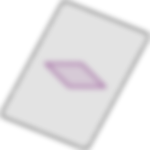

2-red-empty-oval-1.15-9-2.6.png, size: (150, 150)


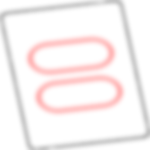

3-green-empty-bean-1.16-332-2.8.png, size: (150, 150)


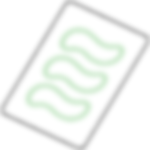

2-purple-striped-diamond-1.18-5-2.6.png, size: (150, 150)


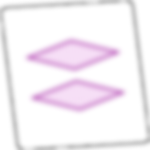

1-purple-solid-oval-0.97-9-0.9.png, size: (150, 150)


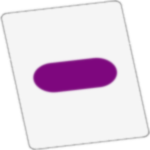

In [9]:
from IPython import display

output_directory = 'rgba-images'
images = random.sample(os.listdir(output_directory), 5)
for filename in images:
  print filename
  path = os.path.join(output_directory, filename)
  display.display(display.Image(filename=path))